In [7]:
from random import randint, betavariate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from datetime import datetime, timedelta, date, time
import pylab
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline
pylab.rcParams['figure.figsize'] = (10, 4)

<ipython-input-7-c95f2d53a1c0>:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


---

The *iCafe_train.xlsx* file contains one day's data from an internet cafe. The cafe takes orders for prepared food and delivers it to customers.  
The table contains columns:
- Order_time - contains information about the time of order placement on the website, the time is represented by a string of the form 'h:mm:ss';
- Delivery_time - contains information about the time spent on delivery, the time is represented by an integer and characterizes the number of minutes required for delivery from the cafe premises to the client;
- Office - characteristic of the delivery place:
    - 1 - if the delivery was made to the client's place of work;
    - 0 - if the delivery was made to the residential sector.

Our task will be to determine where the order was delivered, based on the data on the time of its placement and delivery.

In [2]:
df = pd.read_excel('iCafe_train.xlsx')
df

,Order_time,Delivery_time,Office
0,0:03:35,12,0
1,0:07:14,6,1
2,0:11:30,9,1
3,0:13:48,12,0
4,0:14:36,2,1
...,...,...,...
275,23:39:14,3,1
276,23:40:55,9,1
277,23:45:19,6,1
278,23:47:07,4,1


In [3]:
df['Order_time_sec'] = pd.to_timedelta(df.Order_time) // np.timedelta64(1,'s')

In [4]:
df.describe()

,Delivery_time,Office,Order_time_sec
count,280.000000,280.000000,280.000000
mean,7.675000,0.650000,50935.935714
std,3.303862,0.477824,18926.037837
min,2.000000,0.000000,215.000000
25%,5.000000,0.000000,41675.250000
50%,8.000000,1.000000,45775.000000
75%,9.000000,1.000000,68300.000000
max,18.000000,1.000000,86178.000000


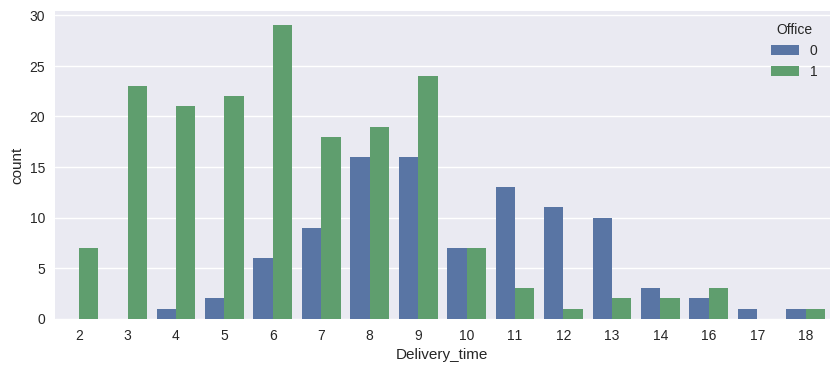

In [8]:
#Construct a chart that represents the number of office and non-office deliveries for each delivery time
sns.countplot(x = 'Delivery_time', hue = 'Office', data = df)
plt.show()

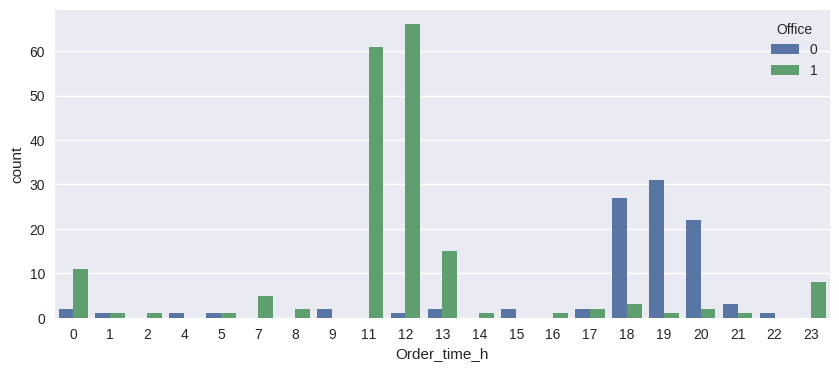

In [9]:
#We make a diagram, where for each hour of order placement time the number of deliveries is presented to the office and not to the office
df['Order_time_h'] = df.Order_time_sec//3600
sns.countplot(x = 'Order_time_h', hue = 'Office', data = df)
plt.show()

In [10]:

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

---

To analyze the obtained result, let's write a function *Processing_results()* to which the values are passed:
- sc - valid (obtained during classifier development) data standardization method;
- lr - classifier;
- df - dataframe;
- target - name of the target attribute column;
- attribute_name - list of attribute column names;
- name - name string of the analyzed result;
- add_schedule - list of feature lists for which additional graphs are to be plotted (optional parameter)

In [22]:
sc = StandardScaler()
lr = LogisticRegression(random_state=21)

y = df.Office
X = df[['Order_time_sec', 'Delivery_time']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=21)
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)
lr.fit(X_train_std, y_train)

LogisticRegression(random_state=21)

In [25]:
def Processing_results(sc, lr, df, target, attribute_name, name, add_schedule = []):
    X_std = sc.transform(df[attribute_name])
    new_col_name = []
    for i, col_name in enumerate(attribute_name):
        s = col_name + '_std_' + name
        df[s] = X_std[:,i]
        new_col_name.append(s)
    y_pred = 'y_pred_' + name
    Correct = 'Correct_' + name
    df[y_pred] = lr.predict(X_std)
    df[Correct] = df.Office == df[y_pred]
    print(classification_report(df.Office, df[y_pred]))
    #sns.pairplot(df[[Correct] + new_col_name], hue = Correct, height=round(12/len(new_col_name), 1))
    #plt.show()
    for k in range(len(add_schedule)):
        i,j = add_schedule[k]
        i = i+'_std_'+name
        j = j+'_std_'+name
        plt.scatter(df[i][True ^ df[Correct]], df[j][True ^ df[Correct]], color = 'red')
        plt.scatter(df[i][df[Correct]], df[j][df[Correct]])
        plt.legend(['Defined incorrectly', 'Defined correctly'])
        plt.xlabel(i)
        plt.ylabel(j)
        plt.show()
    return df

              precision    recall  f1-score   support

           0       0.81      0.84      0.82        98
           1       0.91      0.90      0.90       182

    accuracy                           0.88       280
   macro avg       0.86      0.87      0.86       280
weighted avg       0.88      0.88      0.88       280



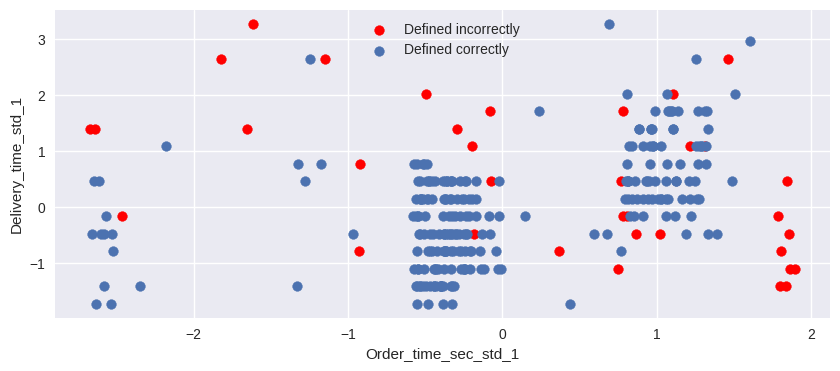

,Order_time,Delivery_time,Office,Order_time_sec,Order_time_h,Order_time_sec_std_1,Delivery_time_std_1,y_pred_1,Correct_1
0,0:03:35,12,0,215,0,-2.670995,1.403727,1,False
1,0:07:14,6,1,434,0,-2.659361,-0.473870,1,True
2,0:11:30,9,1,690,0,-2.645761,0.464929,1,True
3,0:13:48,12,0,828,0,-2.638430,1.403727,1,False
4,0:14:36,2,1,876,0,-2.635880,-1.725600,1,True
...,...,...,...,...,...,...,...,...,...
275,23:39:14,3,1,85154,23,1.841378,-1.412668,0,False
276,23:40:55,9,1,85255,23,1.846744,0.464929,0,False
277,23:45:19,6,1,85519,23,1.860769,-0.473870,0,False
278,23:47:07,4,1,85627,23,1.866506,-1.099735,0,False


In [26]:
y = 'Office'
x = ['Order_time_sec', 'Delivery_time']
df = Processing_results(sc, lr, df, y, x, '1', [x])
df

              precision    recall  f1-score   support

           0       0.86      0.86      0.86        21
           1       0.94      0.94      0.94        47

    accuracy                           0.91        68
   macro avg       0.90      0.90      0.90        68
weighted avg       0.91      0.91      0.91        68



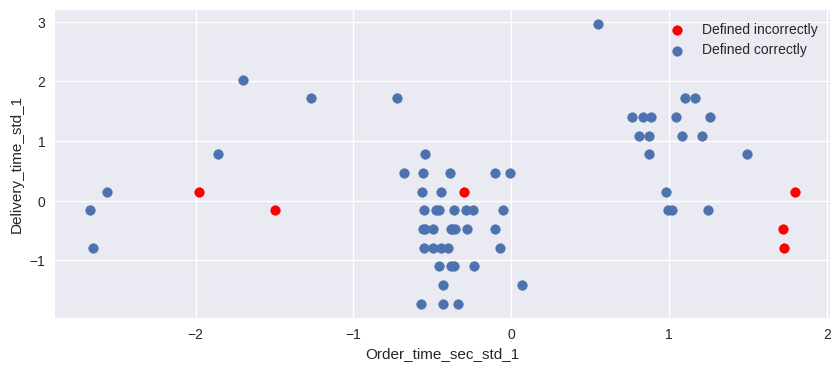

,Order_time,Delivery_time,Office,Order_time_sec,Order_time_sec_std_1,Delivery_time_std_1,y_pred_1,Correct_1
0,0:04:24,7,1,264,-2.668392,-0.160937,1,True
1,0:10:10,5,1,610,-2.650011,-0.786802,1,True
2,0:37:54,8,1,2274,-2.561611,0.151996,1,True
3,3:41:23,8,0,13283,-1.976760,0.151996,1,False
4,4:19:15,10,1,15555,-1.856060,0.777861,1,True
...,...,...,...,...,...,...,...,...
63,20:37:29,12,0,74249,1.262051,1.403727,0,True
64,21:49:31,10,0,78571,1.491657,0.777861,0,True
65,23:02:09,6,1,82929,1.723175,-0.473870,0,False
66,23:03:24,5,1,83004,1.727160,-0.786802,0,False


In [27]:
df_test = pd.read_excel('iCafe_test.xlsx')
df_test['Order_time_sec'] = pd.to_timedelta(df_test.Order_time)//np.timedelta64(1,'s')
df_t1=df_test

y1 = 'Office'
x1 = ['Order_time_sec', 'Delivery_time']
df_test1 = Processing_results(sc, lr, df_t1, y1, x1, '1', [x])
df_test1

In [28]:
df_test.Delivery_time[True^df_test.Correct_1]

3     8
6     7
36    8
65    6
66    5
67    8
Name: Delivery_time, dtype: int64

In [43]:
df_test.Order_time_sec[True^df_test.Correct_1]

3     13283
6     22301
36    44836
65    82929
66    83004
67    84318
Name: Order_time_sec, dtype: int64

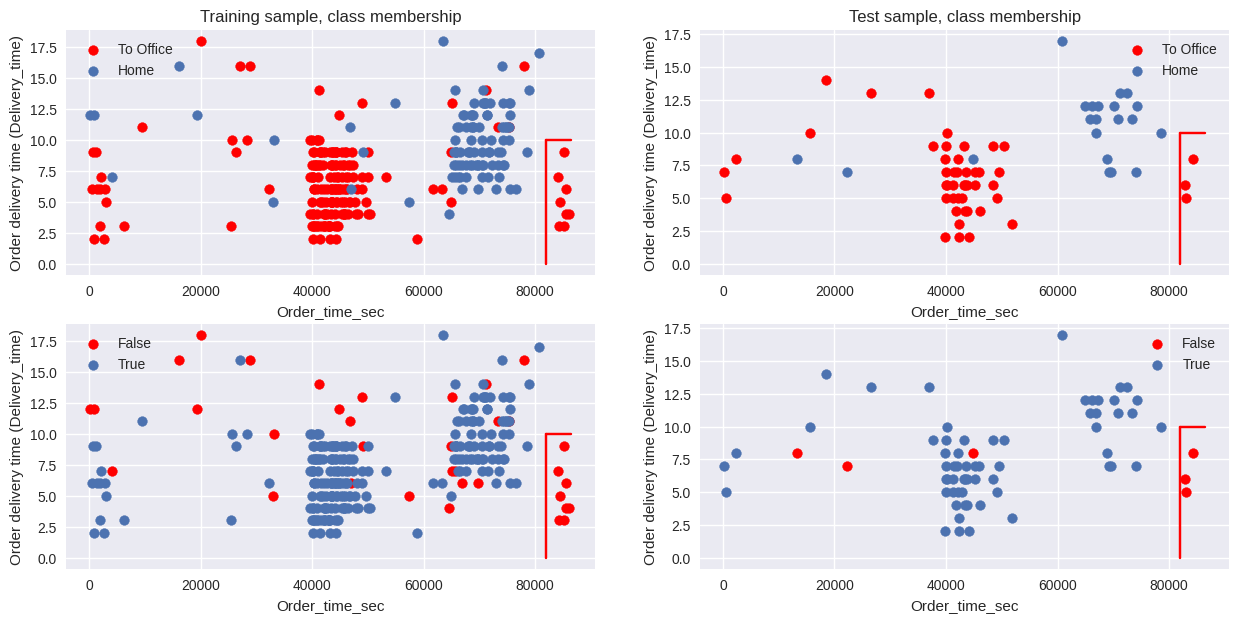

In [42]:
%matplotlib inline
pylab.rcParams['figure.figsize'] = (15, 7)
plt.subplot (2, 2, 1)
plt.scatter(df.Order_time_sec[df.Office == 1], df.Delivery_time[df.Office == 1], color = 'red')
plt.scatter(df.Order_time_sec[df.Office == 0], df.Delivery_time[df.Office == 0])
plt.legend(['To Office', 'Home'])
plt.xlabel('Order_time_sec')
plt.ylabel('Order delivery time (Delivery_time)')
plt.plot([82000, 82000], [0,10], 'red')
plt.plot([82000, 86400], [10,10], 'red')
plt.title('Training sample, class membership')

plt.subplot (2, 2, 2)
plt.scatter(df_test.Order_time_sec[df_test.Office == 1], df_test.Delivery_time[df_test.Office == 1], color = 'red')
plt.scatter(df_test.Order_time_sec[df_test.Office == 0], df_test.Delivery_time[df_test.Office == 0])
plt.legend(['To Office', 'Home'])
plt.xlabel('Order_time_sec')
plt.ylabel('Order delivery time (Delivery_time)')
plt.plot([82000, 82000], [0,10], 'red')
plt.plot([82000, 86400], [10,10], 'red')
plt.title('Test sample, class membership')

plt.subplot(2, 2, 3)
plt.scatter(df.Order_time_sec[True^df.Correct_1], df.Delivery_time[True^df.Correct_1], color = 'red')
plt.scatter(df.Order_time_sec[df.Correct_1], df.Delivery_time[df.Correct_1])
plt.legend(['False', 'True'])
plt.xlabel('Order_time_sec')
plt.ylabel('Order delivery time (Delivery_time)')
plt.plot([82000, 82000], [0,10], 'red')
plt.plot([82000, 86400], [10,10], 'red')
#plt.title('Training sample, class prediction')

plt.subplot (2, 2, 4)
plt.scatter(df_test.Order_time_sec[True^df_test.Correct_1], df_test.Delivery_time[True^df_test.Correct_1],
            color = 'red')
plt.scatter(df_test.Order_time_sec[df_test.Correct_1], df_test.Delivery_time[df_test.Correct_1])
plt.legend(['False', 'True'])
plt.xlabel('Order_time_sec')
plt.ylabel('Order delivery time (Delivery_time)')
plt.plot([82000, 82000], [0,10], 'red')
plt.plot([82000, 86400], [10,10], 'red')
#plt.title('Test sample, class prediction')
plt.show()

On the graphs we see the same area where representatives of the same class are predicted incorrectly on both training and test samples. Let's try to fix it!

1. We need to write a function time_change(df), which writes the Order_time_sec_delta column to the dataframe df and returns the resulting dataframe. The Order_time_sec_delta column differs from the Order_time_sec column by a constant. In the Order_time_sec column, the time stamps are arranged so that the last "home" order (Office = 0) is at 86399 seconds from the start of the day (i.e. exactly 24 hours after the start). In this function, we need to "shift" the time of all orders cyclically to the left, closer to the beginning of the day, by a delta equal to the difference \[24 hours - the maximum time of a home order in the entire dataframe].
2. We need to write a function log_reg(y, X) that takes as input the target feature y and the columns of the dataframe X representing the features. The function returns the trained objects sc and lr

In [44]:
def time_change(df):
    max_time_delivery=df.query("Office==0").Order_time_sec.max()
    delta = 24*60*60-max_time_delivery-1 #24*60*60 seconds in a day
    df['Order_time_sec_delta']=df['Order_time_sec']+delta
    df['Order_time_sec_delta']=df.Order_time_sec_delta.apply(lambda x: x - 86400 if x > 86400 else x)
    return(df)

def log_reg(y,X):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=21)

    sc = StandardScaler()
    sc=sc.fit(X_train)

    X_train_std = sc.transform(X_train)
    X_test_std = sc.transform(X_test)

    lr = LogisticRegression(random_state=21)
    lr=lr.fit(X_train_std, y_train)

    return (sc, lr)

def Processing_results(sc, lr, df, target, attribute_name, name, add_schedule = []):
    X_std = sc.transform(df[attribute_name])
    new_col_name = []
    for i, col_name in enumerate(attribute_name):
        s = col_name + '_std_' + name
        df[s] = X_std[:,i]
        new_col_name.append(s)
    y_pred = 'y_pred_' + name
    Correct = 'Correct_' + name
    df[y_pred] = lr.predict(X_std)
    df[Correct] = df.Office == df[y_pred]
    print(classification_report(df.Office, df[y_pred]))

In [45]:
df2 = time_change(df)
y2 = 'Office'
x2 = ['Order_time_sec_delta', 'Delivery_time']
sc_delta, lr_delta = log_reg(df2[y2], df2[x2])
df_train2 = Processing_results(sc_delta, lr_delta, df2, y2, x2, 'delta', [x2])
df_train2

              precision    recall  f1-score   support

           0       0.91      0.88      0.90        98
           1       0.94      0.96      0.95       182

    accuracy                           0.93       280
   macro avg       0.93      0.92      0.92       280
weighted avg       0.93      0.93      0.93       280



In [46]:
df_t2 = time_change(df_test)
y2 = 'Office'
x2 = ['Order_time_sec_delta', 'Delivery_time']
df_test2 = Processing_results(sc_delta, lr_delta, df_t2, y2, x2, 'delta', [x])
df_test2

              precision    recall  f1-score   support

           0       1.00      0.86      0.92        21
           1       0.94      1.00      0.97        47

    accuracy                           0.96        68
   macro avg       0.97      0.93      0.95        68
weighted avg       0.96      0.96      0.95        68



Unfortunately, it is not always possible to ensure monotonicity of the target variable from the features without using some additional tools.

Is there any other way to improve the quality of the classifier? It is not only possible, but also necessary.

One way to improve the classifier is to increase the order of the feature space, for example, if it is hard enough to draw a line separating classes in a plane, you can already find a plane in 3D space that will do it better.

All moments of time need to be transformed through sine and cosine, thus forming two features instead of one. This becomes all the more important if we have more than one time period instead of one and there is the possibility of periodic oscillations.

The transformations are made using the following formulas:
$$z_{sin} = sin\left(\frac{2\cdot\mathrm{\pi} \cdot \mathrm{x}}{ \mathrm{K} }\right)$$

$$z_{cos} = cos\left(\frac{2\cdot\mathrm{\pi}\cdot \mathrm{x}}{ \mathrm{K} }\right)$$

Here x is the value of a moment in time and K is the value of a time period in units of moments in time.
For example:
- If the moments of time are measured in seconds and the time period is days, then K=86400;
- if the time moments are measured in days and the time period is a week, then K=7.

Let's carry out the transformation of the time of order receipt:

In [48]:
df['Order_sin'] = np.sin(df.Order_time_sec*math.pi/43200)
df['Order_cos'] = np.cos(df.Order_time_sec*math.pi/43200)
df

,Order_time,Delivery_time,Office,Order_time_sec,Order_time_h,Order_time_sec_std_1,Delivery_time_std_1,y_pred_1,Correct_1,Order_time_sec_delta,Order_time_sec_delta_std_delta,Delivery_time_std_delta,y_pred_delta,Correct_delta,Order_sin,Order_cos
0,0:03:35,12,0,215,0,-2.670995,1.403727,1,False,5877,-2.456039,1.403727,1,False,0.015635,0.999878
1,0:07:14,6,1,434,0,-2.659361,-0.473870,1,True,6096,-2.444885,-0.473870,1,True,0.031556,0.999502
2,0:11:30,9,1,690,0,-2.645761,0.464929,1,True,6352,-2.431846,0.464929,1,True,0.050157,0.998741
3,0:13:48,12,0,828,0,-2.638430,1.403727,1,False,6490,-2.424817,1.403727,1,False,0.060177,0.998188
4,0:14:36,2,1,876,0,-2.635880,-1.725600,1,True,6538,-2.422372,-1.725600,1,True,0.063661,0.997972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,23:39:14,3,1,85154,23,1.841378,-1.412668,0,False,4416,-2.530453,-1.412668,1,True,-0.090488,0.995898
276,23:40:55,9,1,85255,23,1.846744,0.464929,0,False,4517,-2.525309,0.464929,1,True,-0.083171,0.996535
277,23:45:19,6,1,85519,23,1.860769,-0.473870,0,False,4781,-2.511863,-0.473870,1,True,-0.064024,0.997948
278,23:47:07,4,1,85627,23,1.866506,-1.099735,0,False,4889,-2.506362,-1.099735,1,True,-0.056185,0.998420


In [57]:
%matplotlib inline
pylab.rcParams['figure.figsize'] = (10, 4)

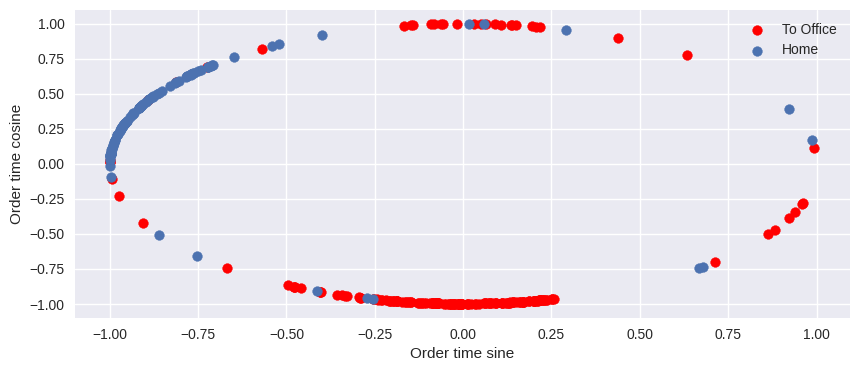

In [58]:
plt.scatter(df.Order_sin[df.Office == 1], df.Order_cos[df.Office == 1], color = 'red')
plt.scatter(df.Order_sin[df.Office == 0], df.Order_cos[df.Office == 0])
plt.legend(['To Office', 'Home'])
plt.xlabel('Order time sine')
plt.ylabel('Order time cosine')
plt.show()

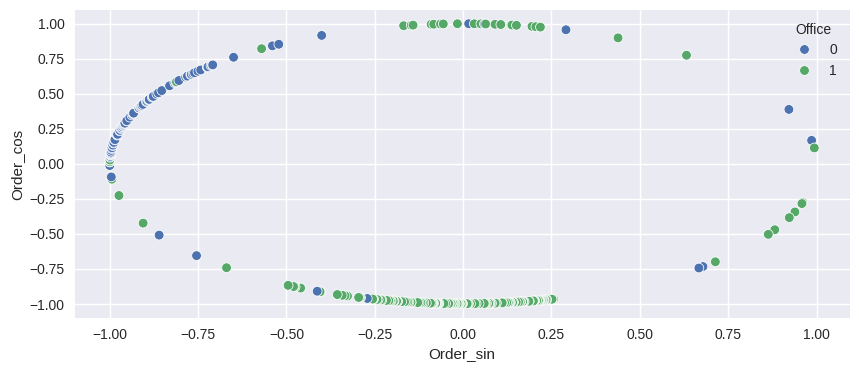

In [59]:
sns.scatterplot(x = 'Order_sin', y = 'Order_cos', data = df, hue = 'Office')
plt.show()

In [60]:
y = df.Office
X = df[['Order_sin', 'Order_cos', 'Delivery_time']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=21)

sc_2 = StandardScaler()
sc_2.fit(X_train)
X_train_std = sc_2.transform(X_train)
X_test_std = sc_2.transform(X_test)

lr_2 = LogisticRegression(random_state=21)
lr_2.fit(X_train_std, y_train)

y_pred_2 = lr_2.predict(X_test_std)

#print(classification_report(y_test, y_pred_2))

y = 'Office'
X = ['Order_sin', 'Order_cos', 'Delivery_time']
x = ['Order_sin', 'Order_cos']
df3 = Processing_results(sc_2, lr_2, df, y, X, '2', [x])
df3

              precision    recall  f1-score   support

           0       0.90      0.91      0.90        98
           1       0.95      0.95      0.95       182

    accuracy                           0.93       280
   macro avg       0.92      0.93      0.93       280
weighted avg       0.93      0.93      0.93       280



In [61]:
df_t3=df_test
df_t3['Order_sin'] = np.sin(df_t3.Order_time_sec*math.pi/43200)
df_t3['Order_cos'] = np.cos(df_t3.Order_time_sec*math.pi/43200)

y3 = 'Office'
X3 = ['Order_sin', 'Order_cos', 'Delivery_time']
x3 = ['Order_sin', 'Order_cos']
df_test3 = Processing_results(sc_2, lr_2, df_t3, y3, X3, '2', [x])
df_test3

              precision    recall  f1-score   support

           0       0.95      0.86      0.90        21
           1       0.94      0.98      0.96        47

    accuracy                           0.94        68
   macro avg       0.94      0.92      0.93        68
weighted avg       0.94      0.94      0.94        68



Now let's take the time shifted data, perform a transformation through sine and cosine, build a classifier and compare the results.

In [63]:
df['Order_sin_new'] = np.sin(df.Order_time_sec_delta*math.pi/43200)
df['Order_cos_new'] = np.cos(df.Order_time_sec_delta*math.pi/43200)
df.head()

,Order_time,Delivery_time,Office,Order_time_sec,Order_time_h,Order_time_sec_std_1,Delivery_time_std_1,y_pred_1,Correct_1,Order_time_sec_delta,...,Correct_delta,Order_sin,Order_cos,Order_sin_std_2,Order_cos_std_2,Delivery_time_std_2,y_pred_2,Correct_2,Order_sin_new,Order_cos_new
0,0:03:35,12,0,215,0,-2.670995,1.403727,1,False,5877,...,False,0.015635,0.999878,0.593465,1.799898,1.403727,0,True,0.414495,0.910052
1,0:07:14,6,1,434,0,-2.659361,-0.473870,1,True,6096,...,True,0.031556,0.999502,0.624683,1.799390,-0.473870,1,True,0.428935,0.903335
2,0:11:30,9,1,690,0,-2.645761,0.464929,1,True,6352,...,True,0.050157,0.998741,0.661154,1.798362,0.464929,1,True,0.445677,0.895194
3,0:13:48,12,0,828,0,-2.638430,1.403727,1,False,6490,...,False,0.060177,0.998188,0.680801,1.797614,1.403727,0,True,0.454638,0.890676
4,0:14:36,2,1,876,0,-2.635880,-1.725600,1,True,6538,...,True,0.063661,0.997972,0.687632,1.797322,-1.725600,1,True,0.457745,0.889084


In [64]:
y = df.Office
X = df[['Order_sin_new', 'Order_cos_new', 'Delivery_time']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=21)

sc_3 = StandardScaler()
sc_3.fit(X_train)
X_train_std = sc_3.transform(X_train)
X_test_std = sc_3.transform(X_test)

lr_3 = LogisticRegression(random_state=21)
lr_3.fit(X_train_std, y_train)

y_pred_3 = lr_3.predict(X_test_std)

y = 'Office'
X = ['Order_sin_new', 'Order_cos_new', 'Delivery_time']
x = ['Order_sin_new', 'Order_cos_new']
df4 = Processing_results(sc_3, lr_3, df, y, X, '3', [x])
df4

              precision    recall  f1-score   support

           0       0.90      0.91      0.90        98
           1       0.95      0.95      0.95       182

    accuracy                           0.93       280
   macro avg       0.92      0.93      0.93       280
weighted avg       0.93      0.93      0.93       280



In [65]:
df_t4=time_change(df_test)
df_t4['Order_sin_new'] = np.sin(df_test.Order_time_sec_delta*math.pi/43200)
df_t4['Order_cos_new'] = np.cos(df_test.Order_time_sec_delta*math.pi/43200)

y4 = 'Office'
X4 = ['Order_sin_new', 'Order_cos_new', 'Delivery_time']
x4 = ['Order_sin_new', 'Order_cos_new']
df_test4 = Processing_results(sc_3, lr_3, df_t4, y4, X4, '4', [x])

              precision    recall  f1-score   support

           0       1.00      0.86      0.92        21
           1       0.94      1.00      0.97        47

    accuracy                           0.96        68
   macro avg       0.97      0.93      0.95        68
weighted avg       0.96      0.96      0.95        68

